In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
TRAIN_DIR = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
TEST_DIR = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 20
MODEL_PATH = "model/model.hdf5"

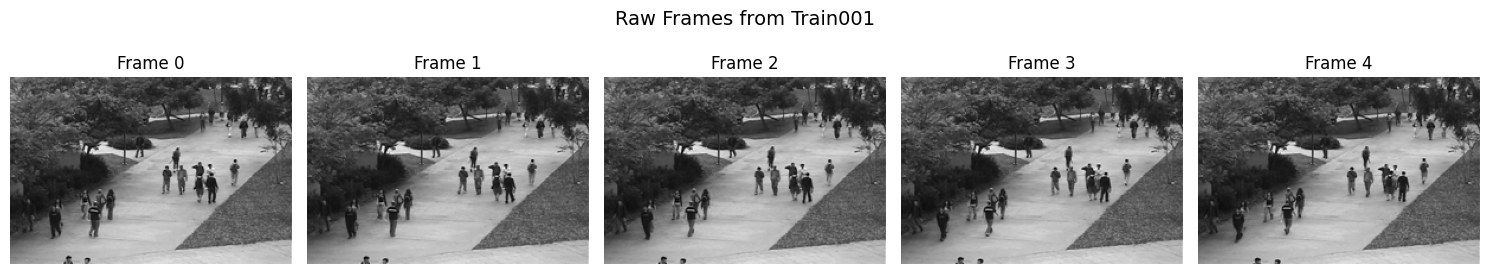

In [4]:
def visualize_frames(folder_dir,folder_name, num_frames=5):
    folder_path = os.path.join(folder_dir, folder_name)
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

    plt.figure(figsize=(15, 3))
    for i in range(num_frames):
        image_path = os.path.join(folder_path, tif_files[i])
        img = cv.imread(image_path, 0)
        
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Frame {i}")
        plt.axis('off')

    plt.suptitle(f"Raw Frames from {folder_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
visualize_frames(TRAIN_DIR, folder_name="Train001", num_frames=5)


### Data Loader

In [5]:
def preprocess_training_clips(filepath, img_size, frames_per_clip=10):
    all_clips = []

    # Iterate over each subfolder (each video sequence)
    for folder in sorted(os.listdir(filepath)):
        folder_path = os.path.join(filepath, folder)

        if os.path.isdir(folder_path):
            frames = []

            # Read and preprocess each .tif image in the folder
            for file in sorted(os.listdir(folder_path)):
                if file.endswith('.tif'):
                    image_path = os.path.join(folder_path, file)

                    # Read in grayscale, resize, normalize
                    img = cv.imread(image_path, 0)
                    img = cv.resize(img, (img_size, img_size), interpolation=cv.INTER_CUBIC)
                    img = img / 255.0
                    frames.append(img)

            # Create clips using non-overlapping windows of frames_per_clip
            num_frames = len(frames)
            for start in range(0, num_frames - frames_per_clip + 1, frames_per_clip):
                clip = np.zeros((frames_per_clip, img_size, img_size, 1))
                for k in range(frames_per_clip):
                    clip[k, :, :, 0] = frames[start + k]
                all_clips.append(clip)

            # Cleanup memory
            del frames
            gc.collect()

    return np.array(all_clips)
    
training_data = preprocess_training_clips(TRAIN_DIR,IMG_SIZE)

In [6]:
print(f"Training data shape: {training_data.shape}")

Training data shape: (680, 10, 224, 224, 1)


### Model building

In [ ]:
# Encoder
model = Sequential()
model.add(TimeDistributed(Conv2D(128, (5, 5), strides=4, padding='same'), input_shape=(10,224,224,1)))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=2, padding='same')))
model.add(LayerNormalization())
#Code
model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())

# Decoder
model.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same')))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2DTranspose(128, (6, 6), strides=4, padding='same')))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(1, (5, 5), activation="sigmoid", padding='same')))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, 10, 56, 56, 128)     │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ (None, 10, 56, 56, 128)     │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 28, 28, 64)      │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_10               │ (None, 10, 28, 28, 64)      │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 10, 28, 28, 64)      │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_11               │ (None, 10, 28, 28, 64)      │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 10, 28, 28, 32)      │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ (None, 10, 28, 28, 32)      │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 10, 28, 28, 64)      │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_13               │ (None, 10, 28, 28, 64)      │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 56, 56, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_14               │ (None, 10, 56, 56, 64)      │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 10, 224, 224, 128)   │         295,040 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_15               │ (None, 10, 224, 224, 128)   │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 10, 224, 224, 1)     │           3,201 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,040,705 (3.97 MB)

 Trainable params: 1,040,705 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
model.fit(training_data, training_data, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False)
model.save(MODEL_PATH)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 97s 401ms/step - loss: 0.0347
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 68s 398ms/step - loss: 0.0070
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - loss: 0.0056
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - loss: 0.0045
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 395ms/step - loss: 0.0039
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 68s 397ms/step - loss: 0.0035
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0032
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0029
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0028
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0026
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0025
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0023
Epoch 13/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 68s 397ms/step - loss: 0.0022
Epoch 14/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 397ms/step - loss: 0.0021
Epoch 15/20
170

In [7]:
from tensorflow.keras.models import load_model

MODEL_PATH = "/kaggle/input/final-model/model (1).hdf5"
model = load_model(MODEL_PATH, compile=False)


I0000 00:00:1751566337.099840      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751566337.100603      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Predict

In [8]:
# Predict reconstruction
def predict_in_batches(model, data, batch_size=8):
    preds = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        pred = model.predict(batch, verbose=0)
        preds.append(pred)
    return np.concatenate(preds, axis=0)

In [9]:
#Training data reconstruction error
train_reconstructed = predict_in_batches(model, training_data, batch_size=8)
train_errors_clip = np.mean((training_data - train_reconstructed)**2, axis=(2, 3, 4)) 
train_errors_frame = train_errors_clip.flatten()

I0000 00:00:1751566361.618879     114 service.cc:148] XLA service 0x22022f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751566361.620437     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751566361.620461     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751566362.144310     114 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751566367.990170     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
threshold = np.mean(train_errors_frame) + 2 * np.std(train_errors_frame)
threshold

0.002404393726994418

In [11]:
#preprocess same as train
test_data = preprocess_training_clips(TEST_DIR, 224)

In [12]:
test_data.shape
reconstructed = predict_in_batches(model, test_data)
frame_errors = np.mean((test_data - reconstructed)**2, axis=(2,3,4))  # shape: (num_clips, 10)
frame_scores = frame_errors.flatten()

In [13]:
np.sum(frame_scores > threshold)

200

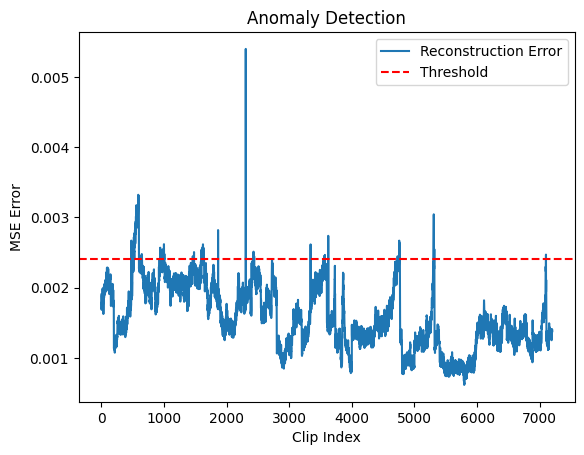

In [14]:
import matplotlib.pyplot as plt

plt.plot(frame_scores, label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.xlabel("Clip Index")
plt.ylabel("MSE Error")
plt.title("Anomaly Detection")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


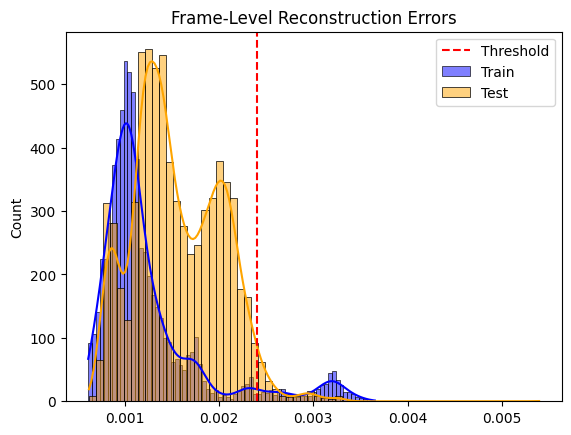

In [15]:
import seaborn as sns

sns.histplot(train_errors_frame, color='blue', label='Train', kde=True)
sns.histplot(frame_scores, color='orange', label='Test', kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Frame-Level Reconstruction Errors")
plt.show()


### AUC-ROC

In [18]:
def preprocess_test_clips(test_dir, frames_per_clip=10, img_size=224):
    clips = []
    folder_list = []

    for folder in sorted(os.listdir(test_dir)):
        if not os.path.isdir(os.path.join(test_dir, folder)):
            continue

        gt_folder = os.path.join(test_dir, folder + "_gt")
        if not os.path.exists(gt_folder):
            continue  # Only process folders with ground truth

        folder_path = os.path.join(test_dir, folder)
        tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
        frames = []

        for f in tif_files:
            path = os.path.join(folder_path, f)
            img = cv.imread(path, 0)
            img = cv.resize(img, (img_size, img_size))
            img = img / 255.0
            frames.append(img)

        # Break into clips
        for i in range(0, len(frames) - frames_per_clip + 1, frames_per_clip):
            clip = np.zeros((frames_per_clip, img_size, img_size, 1))
            for j in range(frames_per_clip):
                clip[j, :, :, 0] = frames[i + j]
            clips.append(clip)
            folder_list.append(folder)  # Track origin

    return np.array(clips), folder_list


In [19]:
test_data, test_clip_folders = preprocess_test_clips(TEST_DIR)


In [20]:
reconstructed_gt = predict_in_batches(model, test_data)
frame_errors_gt = np.mean((test_data - reconstructed_gt)**2, axis=(2,3,4))  # shape: (num_clips, 10)
frame_scores_gt = frame_errors_gt.flatten()

In [21]:
import os
import cv2

def generate_frame_labels(gt_base_dir):
    labels = []
    for folder in sorted(os.listdir(gt_base_dir)):
        if not folder.endswith("_gt"):
            continue

        folder_path = os.path.join(gt_base_dir, folder)
        bmp_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.bmp')])
        for bmp in bmp_files:
            path = os.path.join(folder_path, bmp)
            mask = cv2.imread(path, 0)
            labels.append(1 if np.any(mask > 0) else 0)

    return np.array(labels)

gt_dir = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
frame_labels = generate_frame_labels(gt_dir)


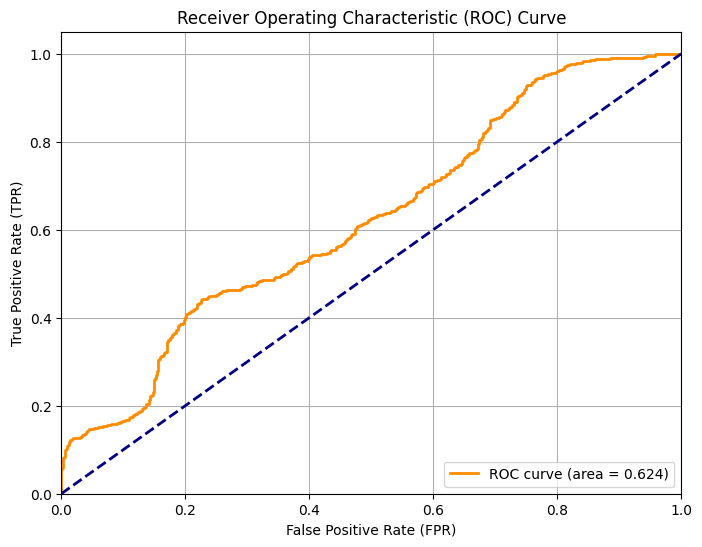

AUC Score: 0.623879759731153


In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# The roc_curve function needs the true labels and the anomaly scores
fpr, tpr, thresholds = roc_curve(frame_labels, frame_scores_gt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc}")